# Problem 2: Autoencoder Neural Network


Homework 3: Feed-foward Neural Network and Autoencoder Network <br>
Due Date: 11/10/22 <br>
Creator: Cat Luong (luongcn@mail.uc.edu)

In [1]:
import random as rand
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
training_set = np.loadtxt('training_set.txt', dtype=float)
test_set = np.loadtxt('test_set.txt', dtype=float)
np.random.shuffle(training_set)

In [3]:
def get_train_data(training_set): # Get the train data from training set
    train_data = [list(x[0:784]) for i, x in enumerate(training_set)]
    np_data = np.array(train_data)
    return np_data

def get_labels(training_set): # Get the label from training set
    labels = [int(x[-1]) for i, x in enumerate(training_set)]
    np_labels = np.array(labels)
    return np_labels

In [4]:
# Parameters initialization
input_neurons = 784 # Corresponds to 28 x 28 image
hidden_neurons = 150 # Between 100 and 200 neurons
output_neurons = 784  # This time the output layer will have the same number of neurons as the input layer
learning_rate = 0.01 # initialize learning rate used for calculation of weight change
momentum = 0.4 # Gradient descent with momentum 
EPOCHS = 1000 # Train on a certain number of EPOCHS

If you are only using one bias make sure to specify that to not lose points in the report

In [5]:
class AutoEncoder():
    def __init__(self, input_neurons, hidden_neurons, output_neurons, learning_rate, momentum, EPOCHS): 
        # Set the hyperparemters for the Auto Encoder
        self.input_neurons = input_neurons
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.bias1 = np.ones((1, self.hidden_neurons)) #initialize biases as arrays of ones
        self.bias2 = np.ones((1, self.output_neurons))
        self.epochs = EPOCHS
        self.hidden_layers = 1

        # Use as place holders to update weight change
        self.pre_delta_w_1 = 0 
        self.pre_delta_w_2 = 0

        # Initialize weights using Xavier's intialization
        self.Wbar_1 = np.random.randn(self.hidden_neurons, self.input_neurons) * np.sqrt(1 / (self.hidden_neurons + self.input_neurons))# Weights for the input layer and the hidden layer
        self.Wbar_2 = np.random.randn(self.output_neurons, self.hidden_neurons) * np.sqrt(1 / (self.output_neurons + self.hidden_neurons))# Weights for the hidden layer and the output layers

    def get_weights(self):
        return self.Wbar_1, self.Wbar_2
    
    def get_output(self):
        return self.yhat_2
    
    def get_hidden(self):
        return self.yhat_1
        
    def print_weights(self):
        print(f"The first set of weights is: \n{self.Wbar_1=}\n")
        print(f"The second set of weights is: \n{self.Wbar_2=}")

    def mean_weights(self):
        print(f"The mean of final weights 1 is: \n{self.Wbar_1.mean()}\n")
        print(f"The mean of final weights 2 is: \n{self.Wbar_2.mean()}")

    def sigmoid(self, z): # Sigmoid: 1/(1 + e^-x)
        return 1.0/(1.0 + np.exp(-z))

    def deri_sigmoid(self, z): # Derivative of Sigmoid
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def ReLU(self, z): # ReLu: max(0, z)
        return np.maximum(0, z)

    def deri_ReLU(self, z): # Derivative of Sigmoid
        return z > 0

    def forward_prop(self, X): # Forward Propagation 
        self.z1 = np.dot(X, self.Wbar_1.T) # Net input 1
        self.yhat_1 = self.sigmoid(self.z1) # activation function for the hidden layer
        self.z2 = np.dot(self.yhat_1, self.Wbar_2.T) + self.bias2 #Net input 2 
        self.yhat_2 = self.sigmoid(self.z2) # activation function for the output layer.
        
    def back_prop(self, X, epoch): # Define Back Propagation, I removed the bias for the first layer to improve the efficiency
        self.output_errors = X - self.yhat_2
        
        self.d_output = self.output_errors * self.deri_sigmoid(self.yhat_2)
        self.d_hidden = self.deri_sigmoid(self.yhat_1) * np.dot(self.d_output, self.Wbar_2)
        delta_w_2 = self.learning_rate*np.dot(np.transpose(self.yhat_1), self.d_output) # Weights change for the second layer (hidden - output)
        delta_w_1 = self.learning_rate*np.dot(np.transpose(X), self.d_hidden) # Weights change for the first layer (input - hidden)
        delta_bias2 =  (self.learning_rate*self.d_output)
        # delta_bias1 =  (self.learning_rate*self.d_hidden)

        if(epoch > 1): #run after epoch = 1 according to the lecture 
            delta_w_2 += (self.momentum*self.pre_delta_w_2) # => THIS IS TO KNOW HOW THE CHANGES ARE UPDATED
            delta_w_1 += (self.momentum*self.pre_delta_w_1)
            delta_bias2 += (self.momentum*self.pre_delta_bias2)
            # delta_bias1 += (self.momentum*self.pre_delta_bias1)
            self.Wbar_2 = self.Wbar_2 + delta_w_2.T # for (hidden - output)
            self.Wbar_1 = self.Wbar_1 + delta_w_1.T # for (input - output)
            self.bias2 = self.bias2 + np.mean(delta_bias2)
            # self.bias1 = self.bias1 + np.mean(delta_bias1)
        
        self.pre_delta_w_2 = delta_w_2 # Keep this value for update of weights change
        self.pre_delta_w_1 = delta_w_1 # Same
        self.pre_delta_bias2 = delta_bias2
        # self.pre_delta_bias1 = delta_bias1

    


Some additional functions I wrote to train the model:

In [6]:
    # The classify() and output() functions are for the winner-takes-all method
    
    def classify(y): # Classify to see the output is which number
        output_lst = []
        for o in y:
            max_output = np.amax(o)
            for i, j in enumerate(o): 
                if j == max_output:
                    output_lst.append(i)
        return np.asarray(output_lst)
        
    def output(y): # Output the index of the entry with the highest value in the output
        max_out = np.amax(y)
        for i, j in enumerate(y): 
                if j == max_out:
                    return i

    def one_hot_encode(y_labels): # onehot encode the outputs
        one_hot_labels = np.zeros((y_labels.size, output_neurons))
        one_hot_labels[np.arange(y_labels.size), y_labels] = 1 
        out_hot_labels = one_hot_labels.T
        return one_hot_labels
    
    def error_fractions(y, yhat): # Get the error fraction
        ERRORS = 0
        yhat_one = one_hot_encode(np.int_(classify(yhat)))
        for i, x in enumerate(y):
            for j in range(len(x)):
                if (y[i][j] != yhat_one[i][j]):
                    ERRORS += 1
                    break
        return (ERRORS/len(y)) * 100
    
    def loss_errors(y, yhat): # Get the loss error 
        error = 0.0
        error += (1.0/2.0 * np.sum(((y - yhat)**2)))
        return error

    def confusion_matrix(y, yhat): # Create a 10 x 10 confusion matrix
        confuse = np.zeros((10,10))
        for i, x in enumerate(y):
            y_output = int(output(y[i]))
            yhat_output = int(output(yhat[i]))
            confuse[y_output][yhat_output] += 1
        return confuse
    
    def get_digits_index(digit, list): # Get the indices of the digits
            indices = []
            for idx, value in enumerate(list):
                if value == digit:
                    indices.append(idx)
            return indices

### Train The Auto Encoder

In [7]:
nn = AutoEncoder(input_neurons, hidden_neurons, output_neurons, learning_rate, momentum, EPOCHS)
X_train = get_train_data(training_set)
y_train = get_labels(training_set)
X_test = get_train_data(test_set)
y_test = get_labels(test_set)

In [8]:
ERROR_train = []
ERROR_epochs = []

In [9]:
for epoch in range(EPOCHS):
    nn.forward_prop(X_train)
    if epoch % 10 == 0:
        print(f"The ERRORS for epoch {epoch} is: {loss_errors(X_train, nn.get_output())}")
        ERROR_train.append(loss_errors(X_train, nn.get_output()))
        ERROR_epochs.append(epoch)
    nn.back_prop(X_train, epoch)    

The ERRORS for epoch 0 is: 718377.2134747888


C:\Users\Admin\AppData\Local\Temp\ipykernel_16252\1073005993.py:40: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


The ERRORS for epoch 10 is: 245104.03219219428
The ERRORS for epoch 20 is: 243562.66790711982
The ERRORS for epoch 30 is: 237892.08968878907
The ERRORS for epoch 40 is: 230764.73153500352
The ERRORS for epoch 50 is: 189109.46259023706
The ERRORS for epoch 60 is: 145263.6412250459
The ERRORS for epoch 70 is: 130308.88097071333
The ERRORS for epoch 80 is: 117352.09574378478
The ERRORS for epoch 90 is: 105271.06813416457
The ERRORS for epoch 100 is: 105072.85903922067
The ERRORS for epoch 110 is: 99832.2292083322
The ERRORS for epoch 120 is: 88720.2089756476
The ERRORS for epoch 130 is: 85269.30709227291
The ERRORS for epoch 140 is: 86277.25637094403
The ERRORS for epoch 150 is: 81468.43370655194
The ERRORS for epoch 160 is: 77603.14735051675
The ERRORS for epoch 170 is: 76751.65927410487
The ERRORS for epoch 180 is: 73385.43684711432
The ERRORS for epoch 190 is: 73286.93252058607
The ERRORS for epoch 200 is: 70565.28355198567
The ERRORS for epoch 210 is: 68243.32119016146
The ERRORS for 

### Plot of Error Fraction over Time Series of Training Set

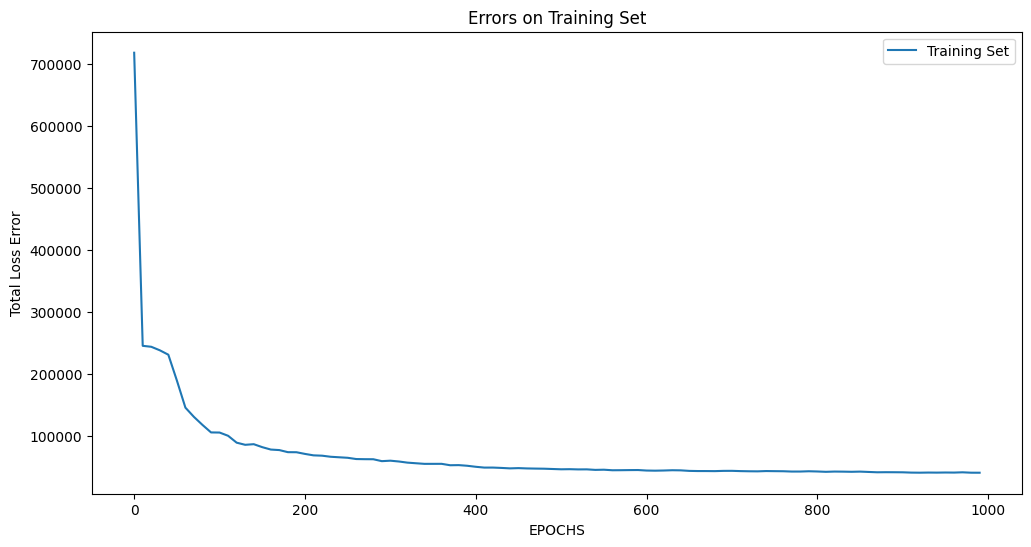

In [10]:
lst_errors = ERROR_train
labels = 'Training Set'
fig, axis = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
plt.plot([i*10 for i in range(len(ERROR_epochs))], lst_errors, label=labels)
plt.title('Errors on Training Set')
plt.xlabel('EPOCHS')
plt.ylabel('Total Loss Error')
plt.legend(loc="upper right")
plt.savefig('problem2_error_fractions.png')
plt.show()

### Test the Outputs after Training

In [11]:
hidden_weights, output_weights = nn.get_weights()

In [12]:
print(hidden_weights.shape)
print(output_weights.shape)


(150, 784)
(784, 150)


In [13]:
rand_num = rand.randint(0, len(X_train) - 1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16252\1073005993.py:40: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


<AxesSubplot: >

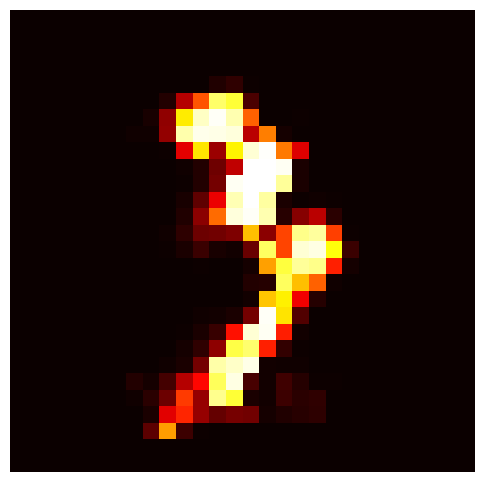

In [14]:
nn.forward_prop(X_train)
actual_output = nn.get_output()
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.heatmap(actual_output[rand_num].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap = 'hot', yticklabels=False, xticklabels=False, cbar = False)

The outputed number should be number 3


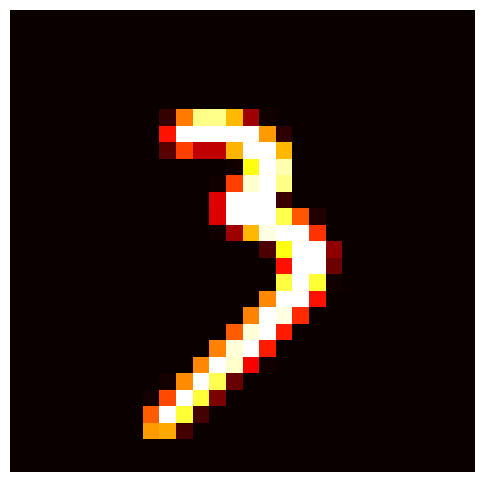

In [15]:
fig, ax0 = plt.subplots(1, 1, figsize = (6, 6))
sns.heatmap(X_train[rand_num].reshape(28, 28).T, ax=ax0, vmin=0, vmax=1, cmap = 'hot', yticklabels=False, xticklabels=False, cbar = False)
print(f"The outputed number should be number {y_train[rand_num]}")

Generate image of a random weight in the two set of weights

<AxesSubplot: >

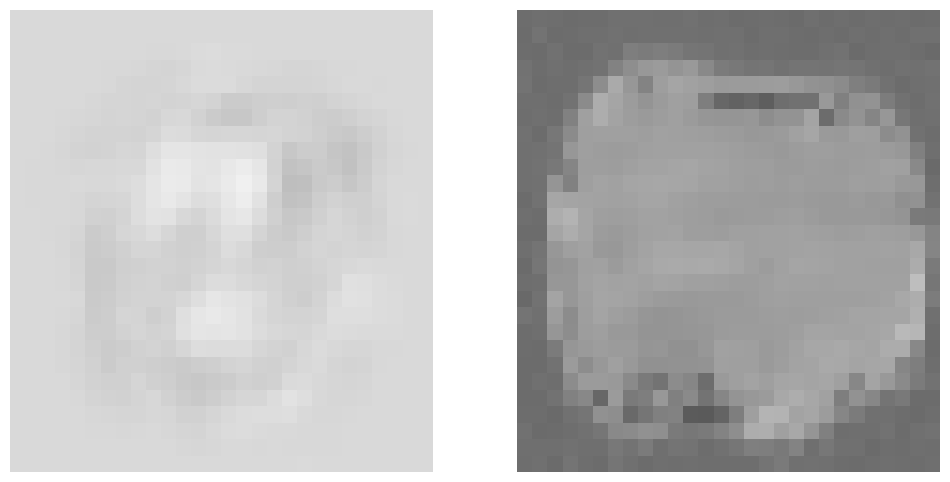

In [16]:
newshape = (28, 28)
norm_weights1 = (hidden_weights-np.min(hidden_weights))/(np.max(hidden_weights)-np.min(hidden_weights))
norm_weights2 = (output_weights-np.min(output_weights))/(np.max(output_weights)-np.min(output_weights))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(norm_weights1[149].reshape(28, 28).T, ax=ax1, vmin=0, vmax=1, cmap = 'gray', yticklabels=False, xticklabels=False, cbar = False)
sns.heatmap(norm_weights2.T[149].reshape(28, 28), ax=ax2, vmin=0, vmax=1, cmap = 'gray', yticklabels=False, xticklabels=False, cbar = False)

Test on the output on a random sample on the test set:

In [17]:
test_rand_num = rand.randint(0, len(X_test) - 1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16252\1073005993.py:40: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


<AxesSubplot: >

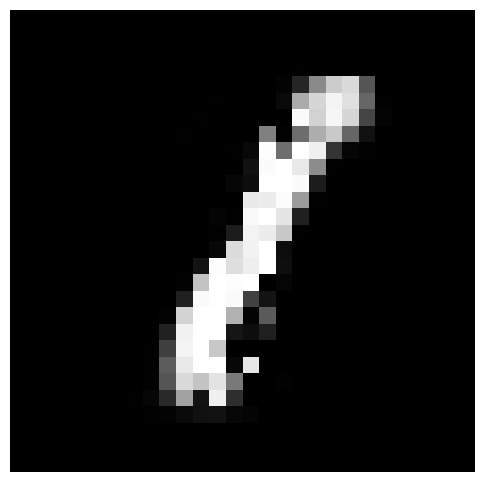

In [18]:
nn.forward_prop(X_test)
test_output = nn.get_output()
fig, ax3 = plt.subplots(1, 1, figsize = (6, 6))
sns.heatmap(test_output[test_rand_num].reshape(28, 28).T, ax=ax3, vmin=0, vmax=1, cmap = 'gray', yticklabels=False, xticklabels=False, cbar = False)

The outputed image should be number 1


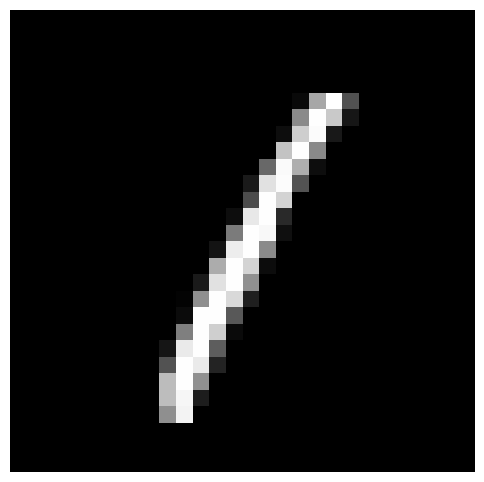

In [19]:
fig, ax4 = plt.subplots(1, 1, figsize = (6, 6))
sns.heatmap(X_test[test_rand_num].reshape(28, 28).T, ax=ax4, vmin=0, vmax=1, cmap = 'gray', yticklabels=False, xticklabels=False, cbar = False)
print(f"The outputed image should be number {y_test[test_rand_num]}")

### Results on Bar Plots

#### Train Set

In [20]:
train_num_dct = {}
for i in range(10):
    train_num_dct[i] = get_digits_index(i, y_train)

In [21]:
def get_error_digit(y, yhat, digit_list):
    error = 0
    for i in digit_list:
        error += (1.0/2.0 * np.sum(((y[i] - yhat[i])**2)))
    return error

In [22]:
ERROR_train = {}
for i in range(10):
    ERROR_train[i] = get_error_digit(X_train, actual_output, train_num_dct[i])
print(sum(ERROR_train.values()))


40707.37991181779


#### Test Set

In [23]:
test_num_dct = {}
for i in range(10):
    test_num_dct[i] = get_digits_index(i, y_test)

In [24]:
ERROR_test = {}
for i in range(10):
    ERROR_test[i] = get_error_digit(X_test, test_output, test_num_dct[i])
print(ERROR_test)

{0: 1285.8349413908602, 1: 594.8028217743303, 2: 1430.3233296255487, 3: 1198.1567913792646, 4: 1075.8061094008349, 5: 1235.6382187505908, 6: 1293.7364812154335, 7: 1041.0502998521067, 8: 1397.29648575641, 9: 1071.987565685298}


In [25]:
print(f"The final error on train set is {sum(ERROR_train.values())}")
print(f"The final error on the test set is {sum(ERROR_test.values())}")

The final error on train set is 40707.37991181779
The final error on the test set is 11624.633044830678


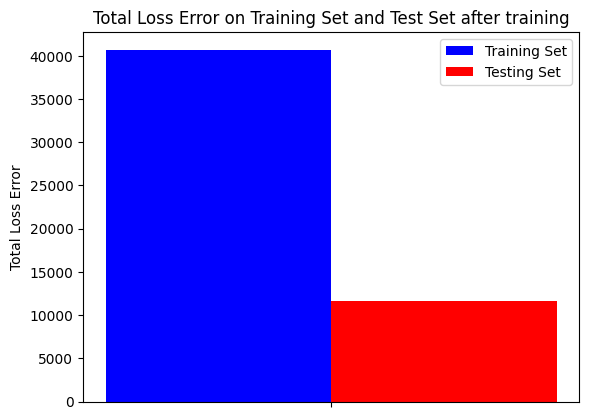

In [26]:
train = sum(ERROR_train.values())
test = sum(ERROR_test.values())

# Calculate optimal width
width = 0.3
indices = np.arange(1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices,train,width,color='b',label='Training Set',align='edge')
ax.bar(indices + width,test,width,color='r',label='Testing Set',align='edge')
ax.legend()
ax.set_title('Total Loss Error on Training Set and Test Set after training')
ax.set_xticks(indices + width, (''))
ax.set_ylabel('Total Loss Error')
plt.savefig('problem2_loss.png')
plt.show()

Plot the bar plot of Total Loss Error by digits in Training set and Test set

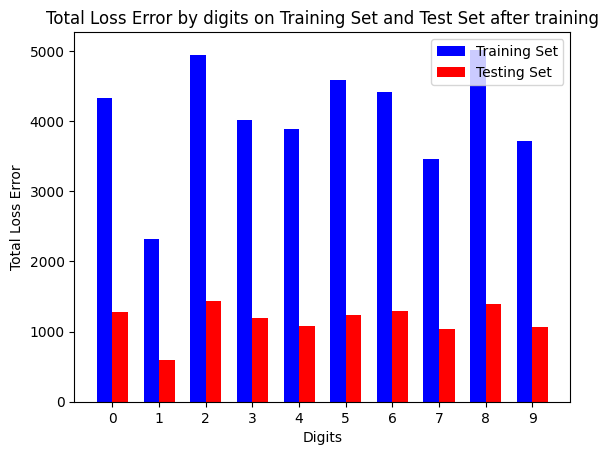

In [27]:
# Transform the train and test data into tuples
train = tuple(ERROR_train.values())
test = tuple(ERROR_test.values())
indices = list(ERROR_train.keys())

# Calculate optimal width
width = np.min(np.diff(indices))/3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width,train,width,color='b',label='Training Set',align='edge')
ax.bar(indices,test,width,color='r',label='Testing Set',align='edge')
ax.legend()
ax.set_title('Total Loss Error by digits on Training Set and Test Set after training')
ax.set_xlabel('Digits')
ax.set_ylabel('Total Loss Error')
ax.set_xticks(indices)
plt.savefig('problem2_loss_digits.png')
plt.show()

### Feature Selection

In [28]:
def get_random(num_output, num_random): #Generate certain random numbers
    lst_hidden = []
    num = rand.randint(0, num_output - 1)
    for i in range(num_random): 
        temp_num = num
        num = rand.randint(0, num_output - 1)
        if temp_num != num: 
            lst_hidden.append(temp_num)
    return lst_hidden

def check_duplicate(lst_hidden): # Test to see if there are duplicates in random numbers, True means no and False means yes
    dup = set([x for x in lst_hidden if lst_hidden.count(x) > 1])
    return dup == set()


In [41]:
# Randomly select hidden neurons:
lst_hidden = get_random(hidden_neurons, num_random = 20)
while check_duplicate(lst_hidden) == False and lst_hidden != 20:
    lst_hidden = get_random(hidden_neurons, num_random = 20)
print(check_duplicate(lst_hidden))

True


In [30]:
nn.forward_prop(X_train)
hidden_output = nn.get_hidden()
AE_hidden_weights, AE_output_weights = nn.get_weights()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16252\1073005993.py:40: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


### Plot the features of the hidden neuron from Autoencoder and the FNN in Problem 1

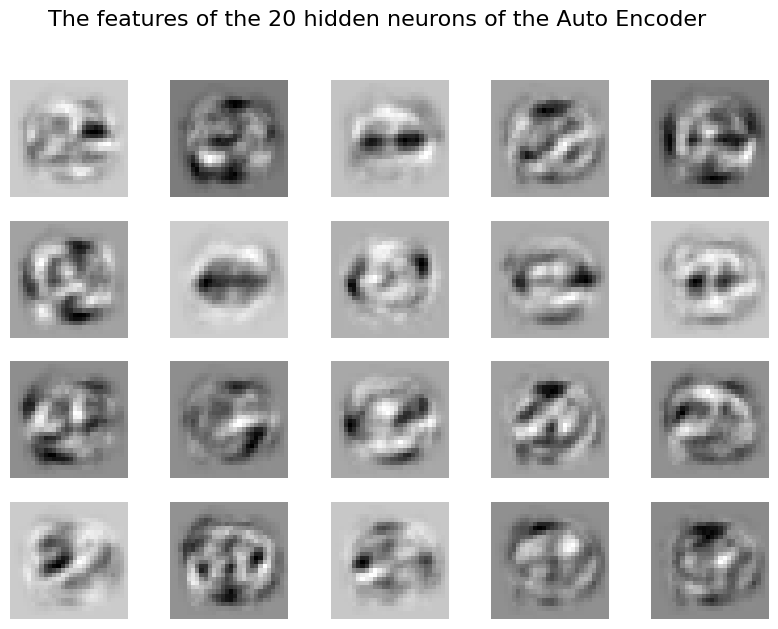

In [42]:
# Plot the features for the hidden output of the Auto Encoder in Problem 2
fig = plt.figure(figsize=(10, 7))
rows = 4
columns = 5
fig.suptitle("The features of the 20 hidden neurons of the Auto Encoder", fontsize = 16)
for i in range(len(lst_hidden)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(AE_hidden_weights[lst_hidden[i]].reshape(28, 28), cmap ="gray")
    plt.axis('off')
plt.savefig('problem2_AE_features.png')
plt.show()

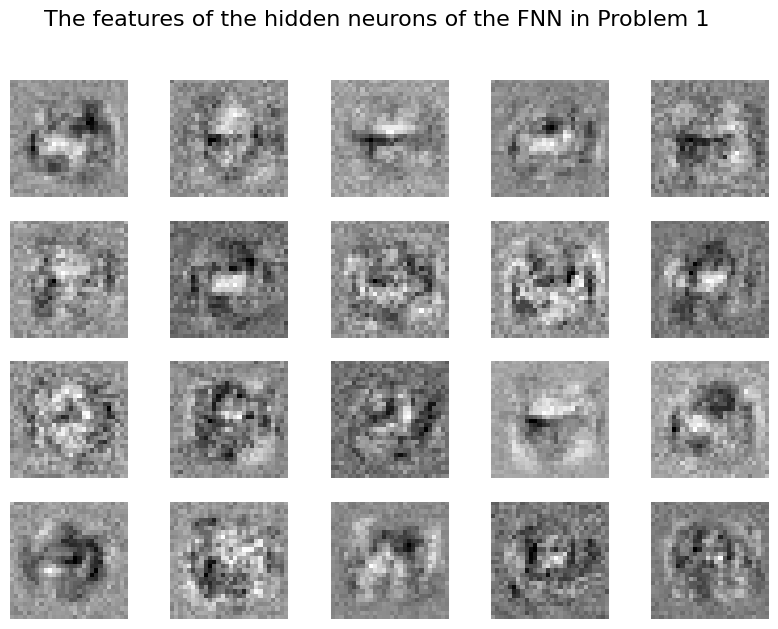

In [43]:
# Plot the features for the hidden output of the Feed-forward Neural Network in Problem 1
FNN_hidden_weights = np.loadtxt('FNN_hidden_weights.txt')
fig = plt.figure(figsize=(10, 7))
rows = 4
columns = 5
fig.suptitle('The features of the hidden neurons of the FNN in Problem 1', fontsize = 16)
for i in range(len(lst_hidden)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(FNN_hidden_weights[lst_hidden[i]].reshape(28, 28), cmap ="gray")
    plt.axis('off')
plt.savefig('problem2_FNN_features.png')
plt.show()

### Sample Outputs

In [33]:
out_random = get_random(len(test_output), num_random = 8)
while check_duplicate(out_random) == False:
    out_random = get_random(len(test_output), num_random = 8)
print(check_duplicate(out_random))

True


In [34]:
print(out_random)

[440, 357, 175, 720, 277, 573, 743, 937]


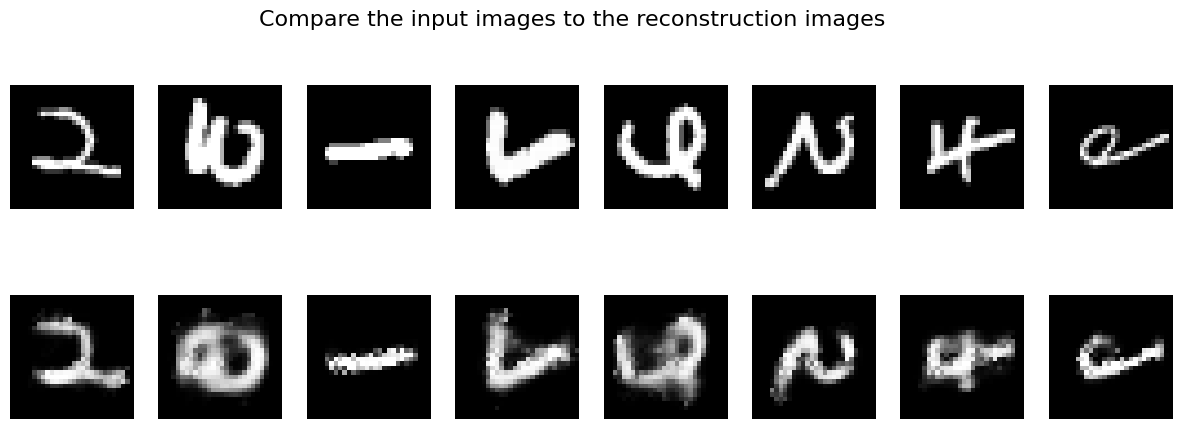

In [44]:
# Randomly selected 8 images of the input and compare them to the outputs
rows = 2
columns = len(out_random)
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Compare the input images to the reconstruction images', fontsize = 16)
# fig1, ax1 = plt.subplots(rows_1, columns, figsize = (10, 7))
# fig2, ax2 = plt.subplots(rows_2, columns, figsize = (10, 7))
for i in range(columns):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(X_test[out_random[i]].reshape(28, 28), cmap="gray")
    plt.axis('off')
    fig.add_subplot(rows, columns, i+9)
    plt.imshow(test_output[out_random[i]].reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.savefig('problem2_reconstruction_outputs.png')
plt.show()

#### Save the hidden weights of the Autoencoder

In [ ]:
np.savetxt('AE_hidden_weights.txt', AE_hidden_weights)